In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:

# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

# 1. Define Thresholds

MOISTURE_THRESHOLDS = {'low': 0, 'medium': 25, 'high': 28}
OIL_THRESHOLDS = {
    'fair': {'low': 23, 'medium': 26.5, 'high': 30},
    'light': {'low': 22, 'medium': 26, 'high': 30},
    'medium': {'low': 21, 'medium': 24.5, 'high': 28},
    'tan_brown': {'low': 20, 'medium': 23, 'high': 26},
    'deep_brown_black': {'low': 19, 'medium': 22, 'high': 25},
    'olive': {'low': 22, 'medium': 25.5, 'high': 29}
}

def get_level(value, thresholds, skin_tone=None):
    """Determine level (low/medium/high) based on value and thresholds"""
    if skin_tone and isinstance(thresholds, dict) and skin_tone in thresholds:
        thresh = thresholds[skin_tone]
    else:
        thresh = thresholds
        
    if value < thresh['medium']:
        return 'low'
    elif value < thresh['high']:
        return 'medium'
    else:
        return 'high'


In [6]:


# 2. Load and Preprocess Dataset

try:
    # Load the dataset
    data = pd.read_csv(r"C:/Users/BHARATH/tone_matched_dataset.csv")
    
    # Clean skin tone names
    data['SkinTone'] = data['SkinTone'].replace({'deep_brow': 'deep_brown_black'})
    
    # Encode skin tones
    le_skin = LabelEncoder()
    data['SkinTone_encoded'] = le_skin.fit_transform(data['SkinTone'])
    
    # Create recommendation classes
    data['RecClass'] = (
        data['SkinTone'] + '_' +
        data['Moisture'].apply(lambda x: get_level(x, MOISTURE_THRESHOLDS)) + '_' +
        data.apply(lambda row: get_level(row['Oil'], OIL_THRESHOLDS, row['SkinTone']), axis=1)
    )
    
    # Encode labels
    le_label = LabelEncoder()
    labels_encoded = le_label.fit_transform(data['RecClass'])
    num_classes = len(le_label.classes_)
    y_cat = to_categorical(labels_encoded, num_classes)
    
    # Scale features
    scaler = MinMaxScaler()
    features = scaler.fit_transform(data[['SkinTone_encoded', 'Moisture', 'Oil']].values)
    
except Exception as e:
    print(f"Error in data preprocessing: {str(e)}")
    raise



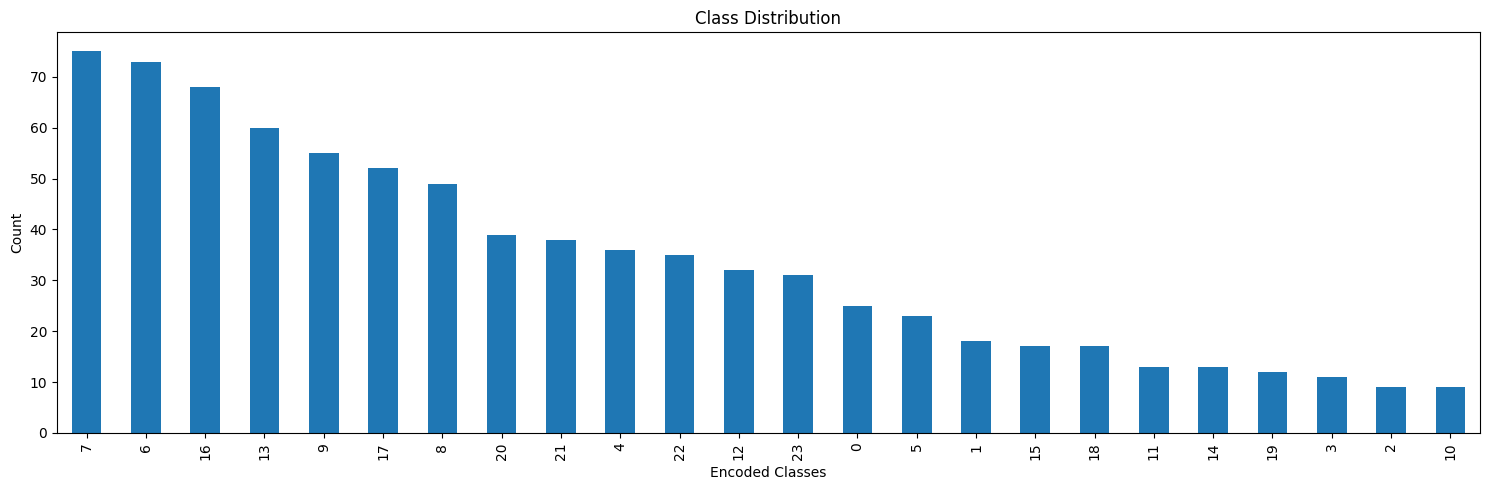

In [7]:

# 3. Visualize Class Distribution

plt.figure(figsize=(15, 5))
pd.Series(labels_encoded).value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Encoded Classes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [9]:

# 4. Split Dataset

X_train, X_test, y_train, y_test = train_test_split(
    features, y_cat, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels_encoded
)

# Calculate class weights for imbalanced classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weight_dict = dict(enumerate(class_weights))


In [10]:

# 5. Build Model (Modified Architecture)

model = Sequential([
    Input(shape=(3,)),
    Dense(64, activation='relu'),  # Reduced complexity
    BatchNormalization(),
    Dropout(0.2),  # Reduced dropout
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

# Modified compilation settings
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modified early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as an improvement
)

# Add learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)



In [11]:

# 6. Train Model

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,  # Reduced batch size
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    shuffle=True
)



Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0483 - loss: 3.4893 - val_accuracy: 0.0864 - val_loss: 3.1294 - learning_rate: 5.0000e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0981 - loss: 2.9609 - val_accuracy: 0.0864 - val_loss: 3.0889 - learning_rate: 5.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1467 - loss: 2.6462 - val_accuracy: 0.0864 - val_loss: 3.0234 - learning_rate: 5.0000e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1930 - loss: 2.4480 - val_accuracy: 0.1852 - val_loss: 2.9324 - learning_rate: 5.0000e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2873 - loss: 2.2521 - val_accuracy: 0.2099 - val_loss: 2.8198 - learning_rate: 5.0000e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3146 - loss: 2.1228 - val_accuracy: 0.2284 - val_loss: 2.6885 - learning_rate: 5.0000e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3549 - loss:

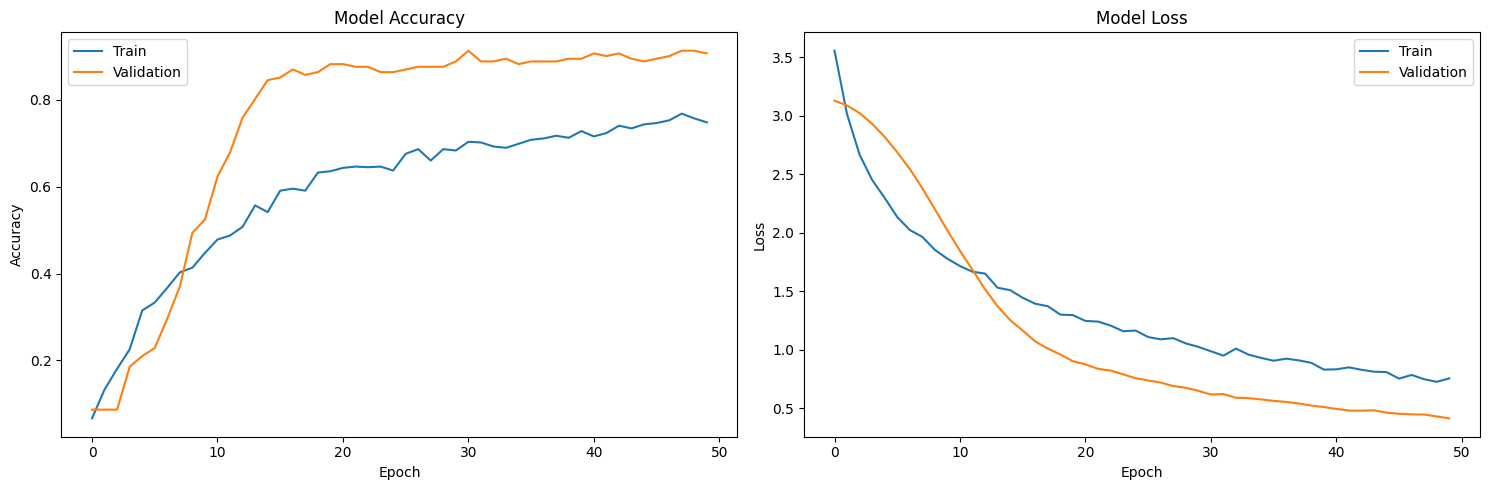

In [12]:

# 7. Plot Training History

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
                                precision    recall  f1-score   support

     deep_brown_black_high_low       0.71      1.00      0.83         5
  deep_brown_black_high_medium       0.75      0.75      0.75         4
      deep_brown_black_low_low       1.00      1.00      1.00         2
   deep_brown_black_low_medium       1.00      1.00      1.00         2
   deep_brown_black_medium_low       1.00      0.86      0.92         7
deep_brown_black_medium_medium       1.00      0.80      0.89         5
                 fair_high_low       1.00      0.87      0.93        15
              fair_high_medium       0.94      1.00      0.97        15
                light_high_low       0.83      1.00      0.91        10
             light_high_medium       1.00      0.91      0.95        11
              light_medium_low       0.67      1.00      0.80         2
           light_medium_medium       0.75      1.00      0.86         3
 

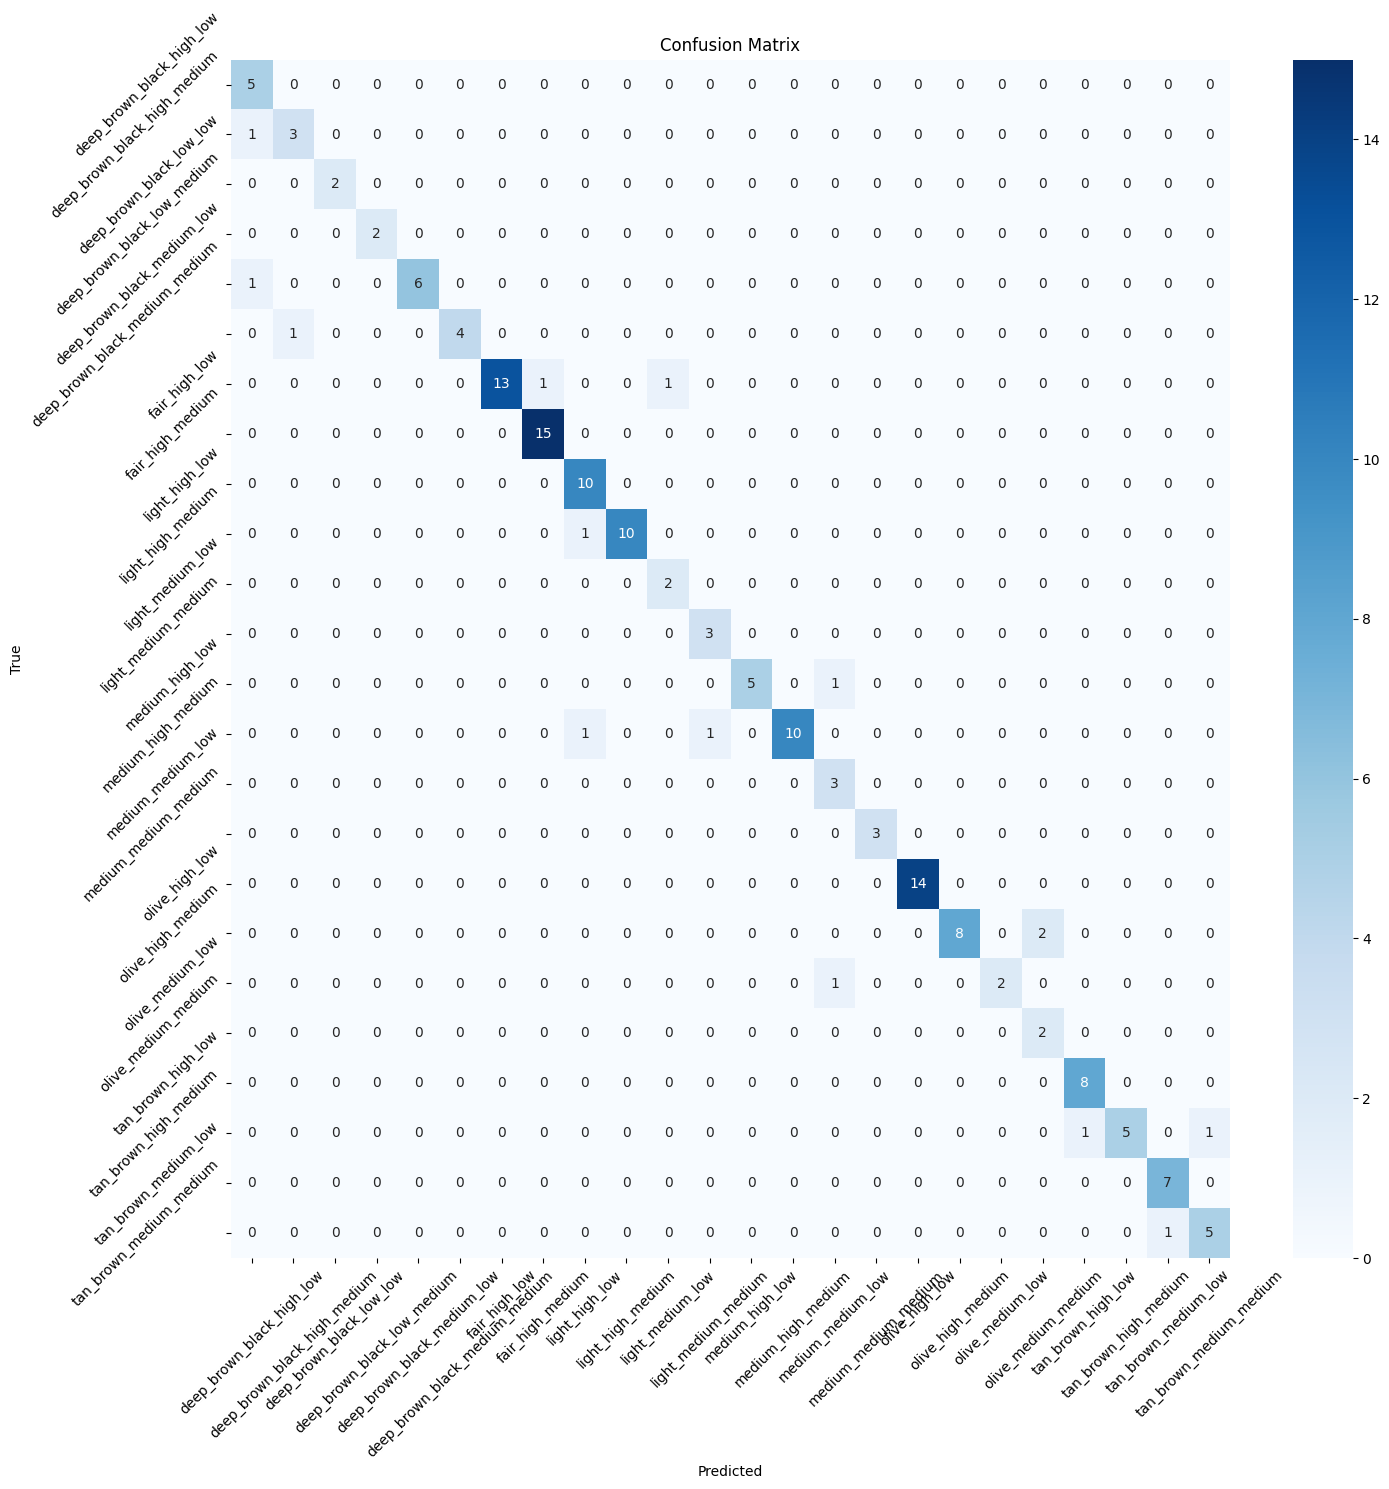

In [13]:

# 8. Evaluate Model

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(
    y_test_classes, 
    y_pred_classes,
    target_names=le_label.classes_
))

# Plot confusion matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_label.classes_,
            yticklabels=le_label.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



In [25]:

# 9. Prediction Function

def predict_skincare_recommendation(skin_tone, moisture_val, oil_val):
    """
    Make a prediction for given input values
    """
    try:
        # Input validation
        if skin_tone not in OIL_THRESHOLDS:
            raise ValueError(f"Invalid skin tone: {skin_tone}")
        
        if not (0 <= moisture_val <= 100):
            raise ValueError(f"Moisture value must be between 0 and 100, got {moisture_val}")
        
        if not (0 <= oil_val <= 100):
            raise ValueError(f"Oil value must be between 0 and 100, got {oil_val}")
        
        # Preprocess input
        skin_tone_encoded = le_skin.transform([skin_tone])[0]
        input_data = scaler.transform([[skin_tone_encoded, moisture_val, oil_val]])
        
        # Make prediction
        pred = model.predict(input_data, verbose=0)
        class_idx = np.argmax(pred)
        confidence = np.max(pred)
        predicted_label = le_label.inverse_transform([class_idx])[0]
        
        # Load recommendations
        with open("D:/Extras/Recommendation_system.json", "r") as f:
            recommendations = json.load(f)
        
        # Get routine
        routine = recommendations.get(predicted_label, {})
        
        return {
            'predicted_class': predicted_label,
            'confidence': float(confidence),
            'morning_routine': routine.get('morning_routine', []),
            'night_routine': routine.get('night_routine', [])
        }
        
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None


In [26]:
# 10. Save Model and Scalers

# Save the trained model (using new .keras format instead of .h5)
model.save('skincare_recommendation_model.keras')  # Changed from .h5 to .keras

# Save the scalers and encoders
import pickle

with open('model_artifacts.pkl', 'wb') as f:
    pickle.dump({
        'scaler': scaler,
        'le_skin': le_skin,
        'le_label': le_label
    }, f)


In [32]:
# Example usage
if __name__ == "__main__":
    # Example prediction
    example_prediction = predict_skincare_recommendation('fair', 26, 28)
    
    if example_prediction:
        print("\nExample Prediction:")
        print(f"Predicted Class: {example_prediction['predicted_class']}")
        print(f"Confidence: {example_prediction['confidence']:.2%}")
        print("\nMorning Routine:")
        for step in example_prediction['morning_routine']:
            print(f"- {step}")
        print("\nNight Routine:")
        for step in example_prediction['night_routine']:
            print(f"- {step}")


Example Prediction:
Predicted Class: light_medium_medium
Confidence: 75.16%

Morning Routine:
- Gentle Cleanser
- Alcohol-free Toner
- Vitamin C Serum
- Lightweight Moisturizer
- Broad Spectrum Sunscreen (SPF 30+)

Night Routine:
- Double Cleanse (Oil-based then Gentle Cleanser)
- Hydrating Toner
- Brightening Serum or Retinol (if not sensitive)
- Rich Moisturizer or Overnight Mask


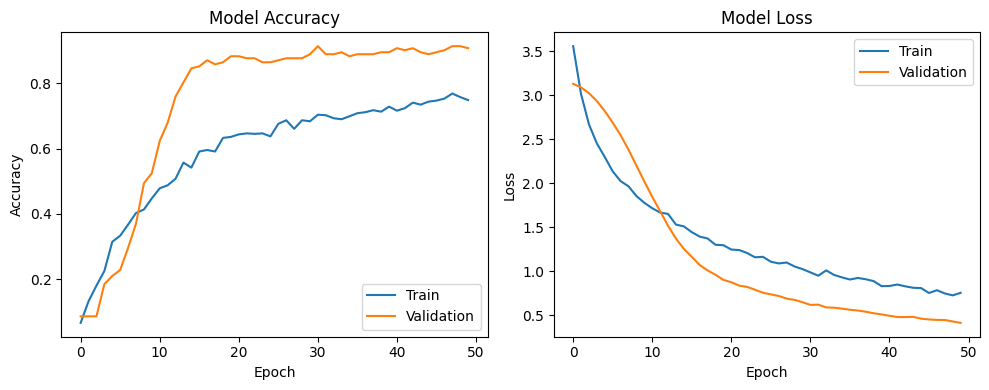

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:

# Generate Recommendations

def get_recommendation(model, scaler, le_skin, le_label, input_data):
    """Generate personalized skincare recommendation"""
    try:
        # Process input
        skin_encoded = le_skin.transform([input_data['SkinTone']])
        features = np.array([
            [skin_encoded[0], input_data['Moisture'], input_data['Oil']]
        ])
        features = scaler.transform(features)
        
        # Predict
        pred = model.predict(features, verbose=0)
        rec_class = le_label.inverse_transform([np.argmax(pred)])
        
        # Get routine from JSON
        with open("D:/Extras/Recommendation_system.json") as f:
            routines = json.load(f)
        return routines.get(rec_class[0], "No recommendation found for this combination")
    
    except Exception as e:
        return f"Error generating recommendation: {str(e)}"


In [40]:
# User Input & Prediction

def get_valid_input(prompt, input_type=float, min_val=None, max_val=None):
    """Validate user input with range checking"""
    while True:
        try:
            value = input_type(input(prompt))
            if min_val is not None and value < min_val:
                print(f"Value must be ≥ {min_val}")
                continue
            if max_val is not None and value > max_val:
                print(f"Value must be ≤ {max_val}")
                continue
            return value
        except ValueError:
            print("Invalid input. Please try again.")

print("\n=== MiDerma Skin Analysis ===")
print("Available skin tones: fair, light, medium, tan_brown, deep_brown_black, olive")

skin_tone = input("Enter your skin tone: ").strip().lower()
while skin_tone not in OIL_THRESHOLDS:
    print("Invalid skin tone. Please choose from:", list(OIL_THRESHOLDS.keys()))
    skin_tone = input("Enter your skin tone: ").strip().lower()

moisture = get_valid_input(
    "Enter your skin moisture value (24-39): ",
    float, 24, 39
)
oil = get_valid_input(
    f"Enter your skin oil value ({OIL_THRESHOLDS[skin_tone]['low']}-{OIL_THRESHOLDS[skin_tone]['high']}): ",
    float,
    OIL_THRESHOLDS[skin_tone]['low'],
    OIL_THRESHOLDS[skin_tone]['high']
)

input_data = {
    'SkinTone': skin_tone,
    'Moisture': moisture,
    'Oil': oil
}

recommendation = get_recommendation(model, scaler, le_skin, le_label, input_data)
print("\n=== Recommended Routine ===")
print(recommendation)


=== MiDerma Skin Analysis ===
Available skin tones: fair, light, medium, tan_brown, deep_brown_black, olive

=== Recommended Routine ===
{'morning_routine': ['Gentle Cleanser', 'Alcohol-free Toner', 'Vitamin C Serum', 'Lightweight Moisturizer', 'Broad Spectrum Sunscreen (SPF 30+)'], 'night_routine': ['Double Cleanse (Oil-based then Gentle Cleanser)', 'Hydrating Toner', 'Brightening Serum or Retinol (if not sensitive)', 'Rich Moisturizer or Overnight Mask']}
